# Lab 6: Graphical Models

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD6"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L6_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from tqdm import tqdm
import networkx as nx
import scipy

In [2]:
class my_GLasso():
    
    def __init__(self, lambd=0.01, nu=0.01, max_iter = 60):
        '''
        Parameters:
        alpha : float
            Penalization parameter selected.
        mu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.lambd = lambd
        self.nu = nu
        self.max_iter = max_iter
        
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # TODO

In [5]:
import numpy as np
from sklearn.linear_model import Lasso

class my_GLasso():
    
    def __init__(self, lambd=0.01, nu=0.01, max_iter=60):
        '''
        Parameters:
        lambd : float
            Penalization parameter for sparsity.
        nu : float
            Convergence threshold.
        max_iter : int
            Maximum number of iterations.
        
        Attributes:
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.precision_ = None
        self.lambd = lambd
        self.nu = nu
        self.max_iter = max_iter
        
    def fit(self, X):
        """ Fits the Graphical Lasso model to X.
        
        Parameters:
        -----------
        X: (n_samples, n_features) np.array
            Data matrix (assumed centered).
        
        Returns:
        --------
        self
        """         
        n_samples, n_features = X.shape
        
        # Step 1: Compute empirical covariance
        S = np.cov(X, rowvar=False)
        
        # Step 2: Initialize precision and covariance matrices
        precision = np.linalg.inv(S + self.lambd * np.eye(n_features))  # Regularized inversion
        covariance = S.copy()
        
        for iteration in range(self.max_iter):
            # Update each variable
            for j in range(n_features):
                mask = np.ones(n_features, dtype=bool)
                mask[j] = False
                
                S_11 = S[np.ix_(mask, mask)]
                S_12 = S[mask, j]
                
                # Solve Lasso problem for column j
                lasso = Lasso(alpha=self.lambd, fit_intercept=False)
                lasso.fit(S_11, S_12)
                
                beta = lasso.coef_
                precision[mask, j] = beta
                precision[j, mask] = beta
                
                # Update diagonal element
                precision[j, j] = 1 / (S[j, j] - np.dot(S_12.T, beta))
            
            # Update covariance matrix
            covariance = np.linalg.inv(precision)
            
            # Check convergence
            if np.max(np.abs(covariance - S)) < self.nu:
                break
        
        # Store results
        self.covariance_ = covariance
        self.precision_ = precision
        
        return self


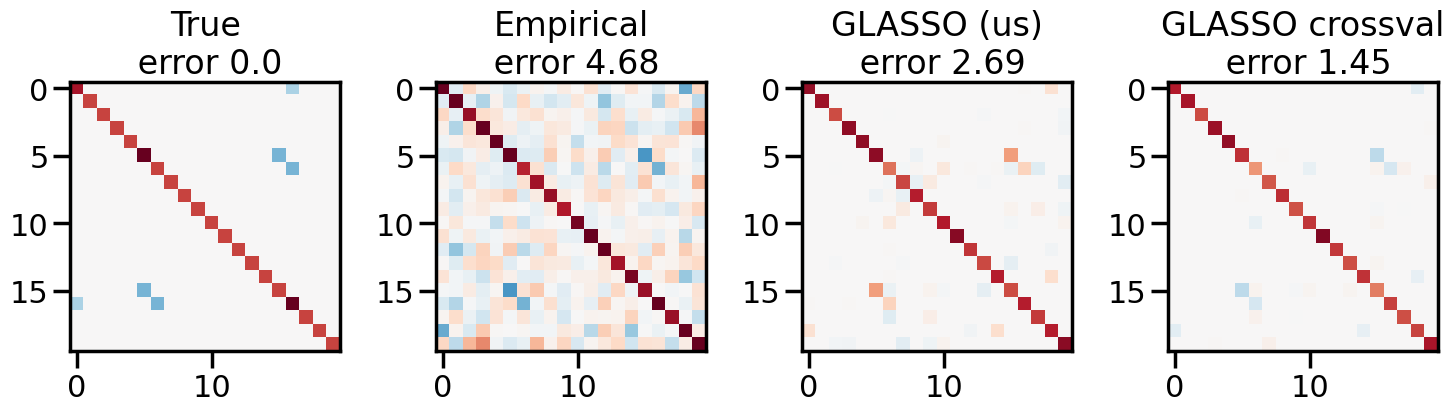

In [6]:
# TODO : Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)

prec = make_sparse_spd_matrix(n_features, alpha=.98, smallest_coef=.4, largest_coef=.7, random_state=rng)
cov = np.linalg.inv(prec)

mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)

err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Scikit-learn Graphical Lasso with cross validation 
from sklearn.covariance import GraphicalLassoCV

graphical_lasso_cv = GraphicalLassoCV()
graphical_lasso_cv.fit(data)
prec_glassocv = graphical_lasso_cv.precision_
err_glassocv = np.linalg.norm(prec - prec_glassocv)


# Graphical Lasso estimation using our implementation
glasso = my_GLasso(lambd=0.01, nu=1e-4, max_iter=100)
glasso.fit(data)
prec_glasso = glasso.precision_
err_glasso = np.linalg.norm(prec - prec_glasso)


# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

vmax = np.abs(prec).max()
ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
fig.tight_layout()

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [7]:
import numpy as np
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule='AND', eps=1e-8):
        '''
        Parameters:
        rule: {"OR", "AND"}
            Rule for determining adjacency from regression coefficients.
        eps: float
            Threshold for considering coefficients nonzero.
        
        Attributes:
        graph_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated adjacency matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.eps = eps
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n_samples, n_features) np.array
            Data matrix.
        
        Returns:
        --------
        self
        """         
        n_samples, n_features = X.shape
        adjacency_matrix = np.zeros((n_features, n_features))
        
        # Perform nodewise regression for each variable
        for j in range(n_features):
            # Target variable
            y = X[:, j]
            
            # Features (excluding column j)
            X_j = np.delete(X, j, axis=1)
            
            # Lasso regression
            lasso = LassoCV(cv=5).fit(X_j, y)
            coefs = lasso.coef_
            
            # Insert coefficients into the adjacency matrix
            adjacency_matrix[j, :] = np.insert(coefs, j, 0)  # Re-insert zero at diagonal
        
        # Apply symmetry rule
        if self.rule == "AND":
            graph_structure = np.minimum(adjacency_matrix, adjacency_matrix.T)  # Element-wise minimum
        elif self.rule == "OR":
            graph_structure = np.maximum(adjacency_matrix, adjacency_matrix.T)  # Element-wise maximum
        else:
            raise ValueError("Invalid rule. Choose 'AND' or 'OR'.")
        
        # Threshold small coefficients
        self.graph_structure_ = (np.abs(graph_structure) > self.eps).astype(int)
        
        return self


In [8]:
np.random.seed(1)
n = 5000
p = 6
epsilon=1e-1
X = np.random.randn(n, p)
X.T[1] += X.T[0]
X.T[2] += X.T[1]
real_graph_structure = np.zeros((p, p))
real_graph_structure[0,1] = 1
real_graph_structure[1,0] = 1
real_graph_structure[1,2] = 1
real_graph_structure[2,1] = 1

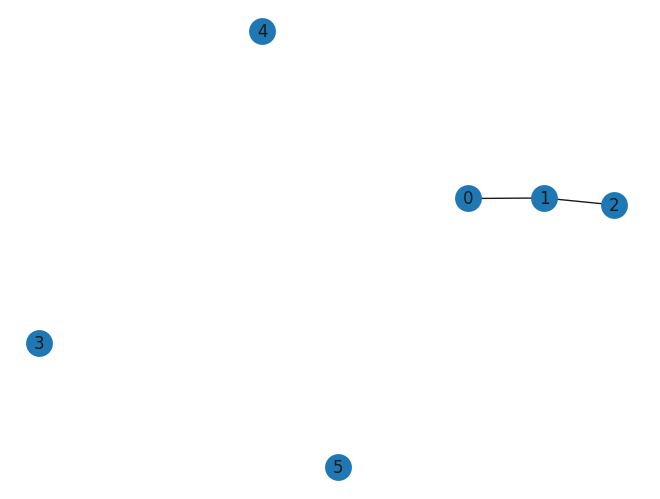

In [10]:
nx_real = nx.from_numpy_array(real_graph_structure.T)
nx.draw(nx_real, with_labels=True)

#On dessine la structure initiale

We notice that the initial graph is **poorly connected**, there are a lot of conditional independances between the components.

When we will reconstruct the graph with the predicted value of the precision matrix, **we expect higher values for the conditional correlation between nodes 0, 1 and 2**. 

However, based on what we saw before, we must expect a complete graph if we dont specify a minimum weight for the edges to be taken into account.

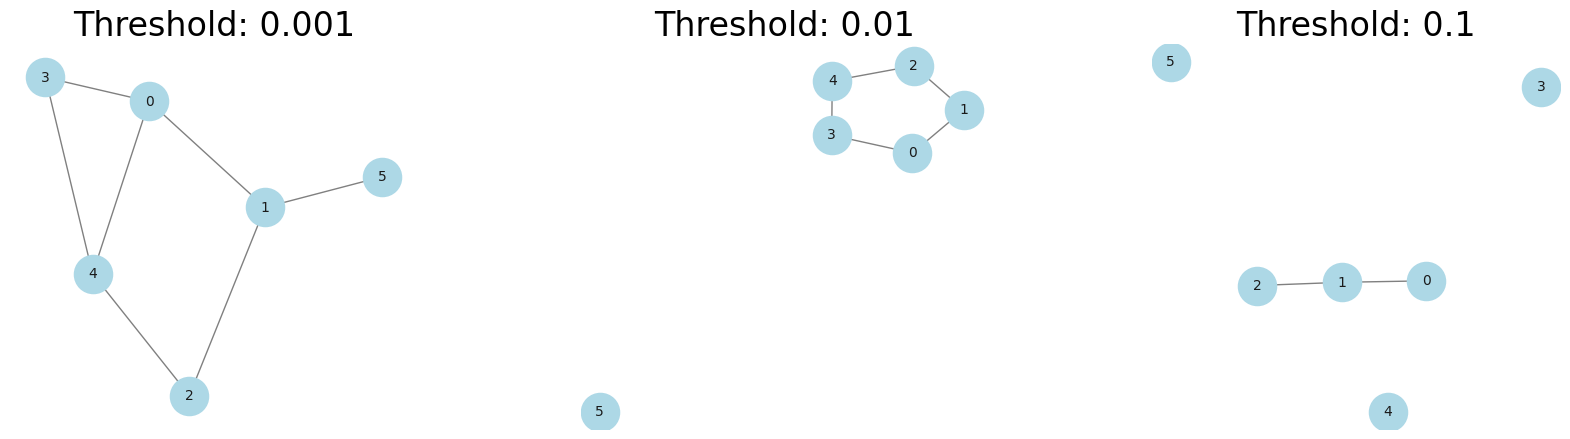

In [26]:
#TODO : plot the reconstructed graph with GLASSO using different thresholds. Comment the impact of the choice of the threshold
# Run GLASSO (Graphical Lasso CV)
glasso = GraphicalLassoCV()
glasso.fit(X)
precision_matrix = glasso.precision_

# Define thresholds
thresholds = [0.001, 0.01, 0.1]

# Plot reconstructed graphs for different thresholds
fig, axes = plt.subplots(1, len(thresholds), figsize=(20, 5))

for idx, threshold in enumerate(thresholds):
    # Threshold the precision matrix to create adjacency matrix
    adj_matrix = (np.abs(precision_matrix) > threshold).astype(int)
    np.fill_diagonal(adj_matrix, 0)  # Remove self-loops
    
    # Create graph
    G = nx.from_numpy_array(adj_matrix)
    
    # Plot graph
    ax = axes[idx]
    nx.draw(
        G, ax=ax, with_labels=True, node_color='lightblue', edge_color='gray',
        node_size=700, font_size=10
    )
    ax.set_title(f"Threshold: {threshold}")

fig.subplots_adjust(wspace=0.4)
plt.show()

C:\Users\bouet\AppData\Local\Temp\ipykernel_9520\3606057812.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


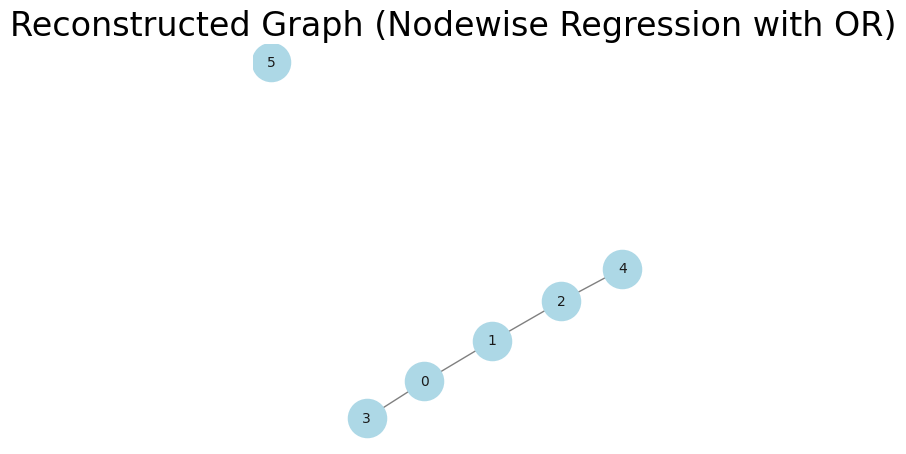

In [31]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR
# Fit Nodewise Regression with "OR" rule
model = my_nodewise_regression(rule='OR')
model.fit(X)
adj_matrix = model.graph_structure_

# Visualize the reconstructed graph
plt.figure(figsize=(4, 4))
nx_reconstructed = nx.from_numpy_array(adj_matrix)
nx.draw(nx_reconstructed, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.title("Reconstructed Graph (Nodewise Regression with OR)")
plt.tight_layout()
plt.show()

C:\Users\bouet\AppData\Local\Temp\ipykernel_9520\589328485.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


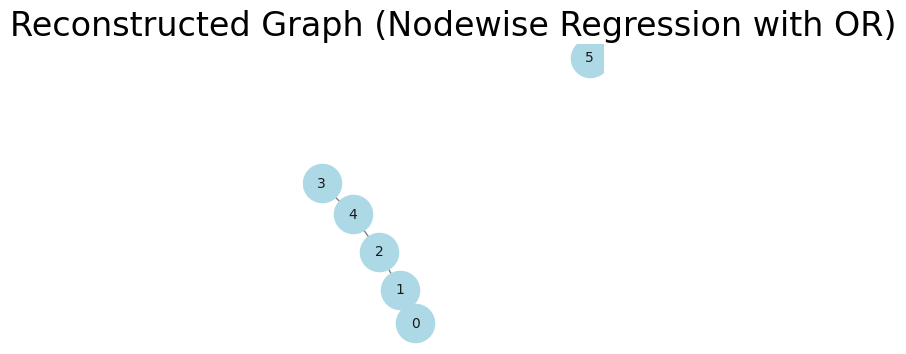

In [33]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR
# Fit Nodewise Regression with "OR" rule
model = my_nodewise_regression(rule='AND')
model.fit(X)
adj_matrix = model.graph_structure_

# Visualize the reconstructed graph
plt.figure(figsize=(3, 3))
nx_reconstructed = nx.from_numpy_array(adj_matrix)
nx.draw(nx_reconstructed, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.title("Reconstructed Graph (Nodewise Regression with OR)")
plt.tight_layout()
plt.show()

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import LassoCV
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics import accuracy_score, f1_score
from scipy.linalg import block_diag

# 1. AR(1)-Block Model Generation
def generate_ar1_block_model(p, n, block_size=30, rho=0.9):
    # Block diagonal covariance matrix with AR(1) structure
    block_cov = np.zeros((block_size, block_size))
    for i in range(block_size):
        for j in range(block_size):
            block_cov[i, j] = rho**abs(i - j)
    
    # Create a block-diagonal covariance matrix
    block_cov_matrix = block_diag(*[block_cov] * (p // block_size))
    
    # Generate data from a multivariate normal distribution
    mean = np.zeros(p)
    X = np.random.multivariate_normal(mean, block_cov_matrix, size=n)
    
    return X, block_cov_matrix

# 2. Exponential Decay Model Generation
def generate_exponential_decay_model(p, n, decay_rate=2):
    # Concentration matrix with exponential decay
    Theta = np.exp(-decay_rate * np.abs(np.subtract.outer(np.arange(p), np.arange(p))))
    
    # Precision matrix is the inverse of the concentration matrix
    cov_matrix = np.linalg.inv(Theta)
    
    # Generate data from a multivariate normal distribution
    mean = np.zeros(p)
    X = np.random.multivariate_normal(mean, cov_matrix, size=n)
    
    return X, Theta

# 3. Frobenius norm for GLASSO estimation
def frobenius_norm(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2, 'fro')

# 4. Main simulation and evaluation code
def compare_estimators(p, n_values, block_size=30, decay_rate=2):
    for n in n_values:
        # AR(1)-Block Model Simulation
        X_ar1, true_cov_ar1 = generate_ar1_block_model(p, n, block_size)
        true_precision_ar1 = np.linalg.inv(true_cov_ar1)
        
        # Exponential Decay Model Simulation
        X_exp, true_precision_exp = generate_exponential_decay_model(p, n, decay_rate)
        
        # Fit GLASSO (Cross-validation for lambda)
        glasso = GraphicalLassoCV()
        glasso.fit(X_ar1)
        precision_ar1_glasso = glasso.precision_
        
        # Nodewise Regression Estimator (OR rule)
        nodewise_model = my_nodewise_regression(rule='OR')
        nodewise_model.fit(X_ar1)
        adj_matrix_ar1_nodewise = nodewise_model.graph_structure_
        
        # GLASSO Estimation Evaluation (AR(1)-Block Model)
        frobenius_glasso_ar1 = frobenius_norm(true_precision_ar1, precision_ar1_glasso)
        
        # Nodewise Regression Estimation Evaluation (AR(1)-Block Model)
        adj_matrix_true_ar1 = (np.abs(true_cov_ar1) > 0).astype(int)
        accuracy_ar1_nodewise = accuracy_score(adj_matrix_true_ar1.flatten(), adj_matrix_ar1_nodewise.flatten())
        f1_ar1_nodewise = f1_score(adj_matrix_true_ar1.flatten(), adj_matrix_ar1_nodewise.flatten())
        
        # Results
        print(f"n = {n} | AR(1)-Block Model")
        print(f"  GLASSO Frobenius Norm: {frobenius_glasso_ar1:.4f}")
        print(f"  Nodewise Regression Accuracy: {accuracy_ar1_nodewise:.4f}")
        print(f"  Nodewise Regression F1 Score: {f1_ar1_nodewise:.4f}")
        
        # Fit GLASSO (Cross-validation for lambda) for Exponential Decay Model
        glasso.fit(X_exp)
        precision_exp_glasso = glasso.precision_
        
        # Nodewise Regression Estimator for Exponential Decay Model
        nodewise_model.fit(X_exp)
        adj_matrix_exp_nodewise = nodewise_model.graph_structure_
        
        # GLASSO Estimation Evaluation (Exponential Decay Model)
        frobenius_glasso_exp = frobenius_norm(true_precision_exp, precision_exp_glasso)
        
        # Nodewise Regression Estimation Evaluation (Exponential Decay Model)
        adj_matrix_true_exp = (np.abs(true_precision_exp) > 0).astype(int)
        accuracy_exp_nodewise = accuracy_score(adj_matrix_true_exp.flatten(), adj_matrix_exp_nodewise.flatten())
        f1_exp_nodewise = f1_score(adj_matrix_true_exp.flatten(), adj_matrix_exp_nodewise.flatten())
        
        # Results
        print(f"n = {n} | Exponential Decay Model")
        print(f"  GLASSO Frobenius Norm: {frobenius_glasso_exp:.4f}")
        print(f"  Nodewise Regression Accuracy: {accuracy_exp_nodewise:.4f}")
        print(f"  Nodewise Regression F1 Score: {f1_exp_nodewise:.4f}")
        print("-" * 50)

# Run the simulations for p = 300 and n = [40, 80, 320]
compare_estimators(p=300, n_values=[40, 80, 320])


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e-02, tolerance: 3.755e-03
  model = cd_fast.enet_coordinate_descent(


n = 40 | AR(1)-Block Model
  GLASSO Frobenius Norm: 161.0983
  Nodewise Regression Accuracy: 0.8922
  Nodewise Regression F1 Score: 0.2233


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\covariance\_graph_lasso.py:159: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\covariance\_graph_lasso.py:160: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.506e-03, tolerance: 5.786e-03
  model = cd_fast.enet_coordinate_descent(
c:\Program1\anaconda3\envs\ml_kaggle\

n = 40 | Exponential Decay Model
  GLASSO Frobenius Norm: 5.5904
  Nodewise Regression Accuracy: 0.0153
  Nodewise Regression F1 Score: 0.0302
--------------------------------------------------


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


n = 80 | AR(1)-Block Model
  GLASSO Frobenius Norm: 161.6804
  Nodewise Regression Accuracy: 0.8963
  Nodewise Regression F1 Score: 0.2147


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


n = 80 | Exponential Decay Model
  GLASSO Frobenius Norm: 4.5458
  Nodewise Regression Accuracy: 0.0174
  Nodewise Regression F1 Score: 0.0343
--------------------------------------------------


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.966e-02, tolerance: 1.940e-02
  model = cd_fast.enet_coordinate_descent(
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e-02, tolerance: 2.103e-02
  model = cd_fast.enet_coordinate_descent(
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628:

n = 320 | AR(1)-Block Model
  GLASSO Frobenius Norm: 155.7069
  Nodewise Regression Accuracy: 0.8979
  Nodewise Regression F1 Score: 0.2114


c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.749e-02, tolerance: 2.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e-02, tolerance: 2.496e-02
  model = cd_fast.enet_coordinate_descent(
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: